In [3]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Data Munging with fastai's Mid-Level API

Sometimes DataBlock API is not enough to do perform a specific task according to requirements.In such
cases mid-level API is used for processing data.It is built on top of DataBlock so it provides 
every functionality of DataBlock API.

## Going Deeper into fastai's Layered API

Fastai library is built on a multilayered API.We saw in first chapter how we can train a model in few 
lines of code.We saw that before creating a learner we create DataLoaders object which splits data
into training and validation sets in batches.For text data we used,

In [4]:
from fastai.text.all import *
dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')

We use above method "TextDataLoaders.from_folder"called factory method to create TextDataLoaders for
a text classifier when the data is arranged in specific folders such as train,test.We can also use 
DataBlock API also to create a datablock object first and then using dataloaders method to create 
Dataloaders object by passing in the path.

In [5]:
path = untar_data(URLs.IMDB)#downloading and decompressing the data
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),#Input Type-Text Block,Output type-Categorical
    get_y = parent_label,#labels using the parent folder name
    get_items=partial(get_text_files, folders=['train', 'test']),#get items using train,test folders
    splitter=GrandparentSplitter(valid_name='test')#"test folder"
).dataloaders(path)

Sometimes we are required to transform data using operations which are not included in DataBlock API 
or sometimes we want to create some DataLoaders for different applications.In this chapter we would 
dig more into DataBlock API and how mid-level offers more flexibility.

### Transforms

Some of the common text transforms we studied in last chapter were tokenization and numericalization.
Let's recall them.

In [6]:
files = get_text_files(path, folders = ['train', 'test']) #getting the text files
txts = L(o.open(errors="ignore").read() for o in files[:2000])# reading the text from some initial
#files

Next we tokenize the text using Tokenizer

In [7]:
tok = Tokenizer.from_folder(path) #Create tokenizer
tok.setup(txts) #set it up by passing texts
toks = txts.map(tok)#mapping the tokenizer to every sentence in the text.
toks[0]

(#207) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has'...]

Next we numericalize the tokens(replacing them with indexes) and create vocab

In [9]:
num = Numericalize() #create Numericalize object
num.setup(toks)#set it up by passing tokens
nums = toks.map(num)#mapping it to every token
nums[0][:10]

tensor([   2,    8,  320,  217,    8,  482,   10,    8, 6383,   69])

We can get the tokens back using decode method on the numericalized tokens

In [10]:
nums_dec = num.decode(nums[0][:10]);#decoding the numerical tokens back to text tokens
nums_dec

(#10) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has']

In [11]:
tok.decode(nums_dec)

'xxbos xxmaj once again xxmaj mr . xxmaj costner has'

In the previous code cells we created tokens and did numericalize the text.First we created an object
then we called setup method on the object ,mapped the object on out raw data and also used decode 
method to get the string back."Numericalize.decode" gives the string tokens and "Toeknizer.decode" 
gives the full string back.
These steps are in general for any Text processing task so fastai has a full class which provides the 
objects such as "Tokenizer" and "Numericalize".Data Augmentation transforms we had applied earlier for
Image Transformation do not have any decode method since we display the transformed images to show
that the augmentation takes place.
We had seen in the earlier chapters that our data is mostly in form of tuples in a dataset.DataSet is 
a special object provided by Fastai and Pytorch which lets us store independent variable and dependent
variables together.These transforms are applied mostly on tuples with Input data and output data.
Whenever these transformations are applied they mostly are applied on tuples as a whole,but we 
want it to be applied only on Input and output separately.In case of Image Segmentation when the input
is Image Block and target is segmentation mask , the transform is applied in same way to both
inputs and targets.

Let's see what happens when we apply tokenizer separately on both the elements in the tuple

In [12]:
tok((txts[0], txts[1]))

((#207) ['xxbos','xxmaj','once','again','xxmaj','mr','.','xxmaj','costner','has'...],
 (#314) ['xxbos','xxmaj','this','is','an','example','of','why','the','majority'...])

### Writing Your Own Transform

We can write functions for the transformations of our choice which we want to apply to our data.In the
function below while passing argument we specify "int" so as to apply Transform only to the matching
data types.Suppose if we pass "a"(character) or "1.0"(float) object the function would return the 
same passed argument and transformation won't take place.

In [13]:
def f(x:int): #function definition(int is passed so that transformation is applied only when it matches)
    return x+1 #return statement
tfm = Transform(f) #create a Transform object and pass f through it
tfm(2),tfm(1.0)
#tfm(2) returns 3 since an integer is passed and transformation
#tfm(1.0) returns 1.0 only since a float is passed.

(3, 1.0)

f is converted into a Transform object without any setup and decode method.Whenever we pass a 
function to an another function,it is called a decorator.Python follows a special syntax for 
decorator.We specify the main function with @ before the definition of the argument function.Thus in 
the below code cell,"Transform" is placed before f definition so that is converted into a transform.

In [14]:
@Transform #the Python decorator for transform(containing @)
def f(x:int): #the argument function definition
    return x+1 #return statement
f(2),f(2.0)
#f(2) returns 3 since int is passed
#f(2.0) returns 2.0 since transformation doesn't take place.It is because the function is a Transform
#object and applies it only when an integer is passed.

(3, 2.0)

If we need to implement setup or decode in the Tranform,we need to create a parent class for Transform
which will implement the setup and decode functions.In the below NormalizeMean class,initially mean of
the object is calculated then transformation is that the mean should be subtracted.During decodes,
the reverse transformation occurs that the mean is added.

In [16]:
class NormalizeMean(Transform):
    def setups(self, items): self.mean = sum(items)/len(items)
    def encodes(self, x): return x-self.mean
    def decodes(self, x): return x+self.mean

Let's see how NormalizeMean is implemented.During initial setup,mean of all items is passed.Then 
transformation occurs in which mean is subtracted.For decoding,reverse of the transformation happens,
and mean is added back.

In [17]:
tfm = NormalizeMean() #creating instance of the class
tfm.setup([1,2,3,4,5]) #passing list of items 
start = 2
y = tfm(start)#transformation applied with x=2.(mean=3)(2-3=-1)
z = tfm.decode(y)#reverse transformation applied on y=-1(-1+mean=-1+3=2)
tfm.mean,y,z

(3.0, -1.0, 2.0)

We can use Transform on different types of inputs.The further tutorials are in fastai docs.

### Pipeline

Several transforms together can be applied using the Pipeline class provided by fastai.A list of 
transforms can be passed through the Pipeline object and the passed transformations can be implemented
.When we pass the text data through the Pipleline object,the transformations occur in order.

In [19]:
tfms = Pipeline([tok, num])
t = tfms(txts[0]); t[:20]

tensor([   2,    8,  320,  217,    8,  482,   10,    8, 6383,   69, 2796,   61,   12,   25,   29,  213, 1357,   98, 2501,   10])

We can pass the transformed text through the decode to get the processed text back.

In [20]:
tfms.decode(t)[:100]

'xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessar'

We saw the Pipeline allows successive transformations on text data.The only thing that doesn't work
the same is the setup.For setting up a Pipeline on transforms,Tfmdlists are used.

## TfmdLists and Datasets: Transformed Collections

Successive transformations are applied to the raw data in Pipeline.In Pipeline we passed the list of
transforms through the Pipeline in order.The class called TfmdLists allows us to pass text data and 
transforms in order through a single object.Later final processed text can be found just by indexing
on the TfmdLists object.

### TfmdLists

Let's create a TfmdLists object by passing text data file containing train and test folder and the 
list of transform objects for Tokenization and numericalization.

In [21]:
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize])

Let's visualize the processed texts by indexing the above created object..

In [22]:
t = tls[0]; 
t[:20]

tensor([   2,    8,  302,  195,    8,  500,   10,    8, 5577,   61, 3407,   62,   13,   30,   29,  249, 1143,   94, 1712,   10])

We can get the encoded string back using the decode method on the transformed object.It is also 
provided by TfmdLists object.

In [23]:
tls.decode(t)[:100]

'xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessar'

TfmdLists also helps us in displaying the text using the show method.

In [24]:
tls.show(t)

xxbos xxmaj once again xxmaj mr . xxmaj costner has dragged out a movie for far longer than necessary . xxmaj aside from the terrific sea rescue sequences , of which there are very few i just did not care about any of the characters . xxmaj most of us have ghosts in the closet , and xxmaj costner 's character are realized early on , and then forgotten until much later , by which time i did not care . xxmaj the character we should really care about is a very cocky , overconfident xxmaj ashton xxmaj kutcher . xxmaj the problem is he comes off as kid who thinks he 's better than anyone else around him and shows no signs of a cluttered closet . xxmaj his only obstacle appears to be winning over xxmaj costner . xxmaj finally when we are well past the half way point of this stinker , xxmaj costner tells us all about xxmaj kutcher 's ghosts . xxmaj we are told why xxmaj kutcher is driven to be the best with no prior inkling or foreshadowing . xxmaj no magic here , it was all i could do to kee

TfmdLists also allows splitting into training and validation sets using splits argument.We need to
pass the list of indexes in training set and validation set through the splits.

In [25]:
cut = int(len(files)*0.8) #defining the number of files in training set
splits = [list(range(cut)), list(range(cut,len(files)))] #index list for training and validation set
tls = TfmdLists(files, [Tokenizer.from_folder(path), Numericalize], 
                splits=splits)
#TfmdLists object.Passed list of transforms and splits(indexes for training and validation split)

This is like dataloaders object and we can also access training and validation sets using.train and 
.valid attributes and indexing them.

In [26]:
tls.valid[0][:20]

tensor([    2,     8,  2302,     8,  9488,  2290,     9,   144,    54,     8,  4994,    54,     8,   118,    98,     8, 16908,     0,    27,    68])

If our Transform function is such that after preprocessing data is converted into tuples of inputs and
targets then we should use TfmdLists.It can be converted into DataLoaders using the dataloaders method

Since in the tuples we would have input as well as targets so we would have to define two transform
pipelines for inputs and targets.One pipeline would be the same where raw data is transformed into 
inputs and for processing raw data into targets.Now for text classification,labels have to be 
processed into targets.
Let's process the labels..

In our dataset here the label is given by the parent folder so we use a parent_label function for the
same.

In [27]:
lbls = files.map(parent_label)
lbls

(#50000) ['neg','neg','neg','neg','neg','neg','neg','neg','neg','neg'...]

Next we need to define a Transform object which will identify unique categories and form thr vocab and
it will also convert the categories into unique integers.Fastai does it through "Categorize" object.

In [29]:
cat = Categorize() #create categorize object
cat.setup(lbls) #set up the object
cat.vocab, cat(lbls[0])#displaying the vocab and the label

((#2) ['neg','pos'], TensorCategory(0, dtype=torch.int32))

Next we create a TfmdLists for label and thus we pass files and for transformation we pass 
parent_label and the Categorize() object which we discussed in the previous code cells.

In [30]:
tls_y = TfmdLists(files, [parent_label, Categorize()])
tls_y[0]

TensorCategory(0, dtype=torch.int32)

Now we have processed labels and our data both but we aim to create a tuple containing input and 
labels together and not separate like we have it now.Earlier in second Lesson we had discussed about 
Datasets objects which convert data into tuples of input and labels.So let's use datasets..

### Datasets

Next we define the transformations for input data(x_tfms) and the transformations for output data.
(y_tfms).We create a Datasets object by passing text files and the x_tfms and y_tfms.

In [31]:
x_tfms = [Tokenizer.from_folder(path), Numericalize] #input data transformations
y_tfms = [parent_label, Categorize()]#target labels transformations
dsets = Datasets(files, [x_tfms, y_tfms])#creating datasets object(list of tuples) by passing 
#data(files) and x_tfms and y_tfms(Transformations)
x,y = dsets[0] #getting input data and label from the data
x[:20],y

(tensor([   2,    8,  302,  195,    8,  500,   10,    8, 5577,   61, 3407,   62,   13,   30,   29,  249, 1143,   94, 1712,   10]),
 TensorCategory(0, dtype=torch.int32))

We can pass splits through Datasets like TfmdLists to split the data into training and validation set.
Rest steps remain the same.We can access the training and validation sets through .train and .valid
attributes

In [32]:
x_tfms = [Tokenizer.from_folder(path), Numericalize]
y_tfms = [parent_label, Categorize()]
dsets = Datasets(files, [x_tfms, y_tfms], splits=splits) #passing splits to split into training and 
#validation sets
x,y = dsets.valid[0]
x[:20],y

(tensor([    2,     8,  2302,     8,  9488,  2290,     9,   144,    54,     8,  4994,    54,     8,   118,    98,     8, 16908,     0,    27,    68]),
 TensorCategory(1, dtype=torch.int32))

Like TfmdLists and decode we can get the text back again using the decode method directly.

In [33]:
t = dsets.valid[0]
dsets.decode(t)

("xxbos xxmaj kate xxmaj beckinsale steals the show ! xxmaj bravo ! xxmaj too bad xxmaj knightly xxunk as good looking as xxmaj jeremy xxmaj northam . xxmaj mark xxmaj strong did a fabulous job . xxmaj bernard xxmaj hepton was perfect as xxmaj xxunk father . i love the end scene ( which is an addition to the novel - but well written ) when the harvest is in and xxmaj knightly xxunk with his workers and high society friends . xxmaj emma must show that she accepts this now . xxmaj she is a changed woman . xxmaj that is too much too quick , but xxup ok . xxmaj i 'll buy into it . xxmaj samantha xxmaj bond plays xxmaj emma 's ex - governess and confidant . xxmaj she is wonderful . just as i would have imagined her . i believe that when the xxup uk does a xxmaj jane xxmaj austen its the best . xxmaj american versions of xxmaj english literature are done for money and not for quality . xxmaj see this one !",
 'pos')

Next we create dataloaders using .dataloaders method.To avoid padding problem we pass before_batch
attribute=pad_input

In [34]:
dls = dsets.dataloaders(bs=64, before_batch=pad_input)

dataloaders method assigns DataLoader for every subset of Datasets.It divides the dataset into mini
batches of same batch size.Some important attributes of dataloaders are as follows:-
1.after_item:transformations on each item.Identical as "item_tfms" in DataBlock.
2.before_batch:Transformations on each list of items(batches).Items should be padded to same size here
3.after_batch:Transformation on a batch as a whole.Identical as "batch_tfms" in DataBlock.Let's 
summarize all the steps we discussed for text processing and classification.

In [35]:
#transforms=[x_tfms,y_tfms]
tfms = [[Tokenizer.from_folder(path), Numericalize], [parent_label, Categorize]]
#get train and test data in different folders
files = get_text_files(path, folders = ['train', 'test'])
#splitting the validation set using the parent test folder
splits = GrandparentSplitter(valid_name='test')(files)
#loading the data into Datasets to convert it into tuples of (input,output)
dsets = Datasets(files, tfms, splits=splits)
#loading the dsets into DataLoaders using the dataloaders method
dls = dsets.dataloaders(dl_type=SortedDL, before_batch=pad_input)

Only differences between the previous steps and this summary is that we use GrandparentSplitter to
split training and validation set and we pass dl_type=SortedDL as argument so as to get sorted data.It
constructs batches with same length of data approximately.
This is same as using DataBlock API which we did earlier.

In [36]:
path = untar_data(URLs.IMDB) #downloading and decompressing dataset
#creating DataBlock
dls = DataBlock(
    blocks=(TextBlock.from_folder(path),CategoryBlock),#Input and output type
    get_y = parent_label,#get target labels(using parent folder)
    get_items=partial(get_text_files, folders=['train', 'test']),#get the text files
    splitter=GrandparentSplitter(valid_name='test')#split into training and validation
).dataloaders(path)#converting into dataloaders using dataloaders attribute

When we created DataBlock changing the different steps or processing individually was not possible
.But using mid-level API it can be done.We did text processing using mid-level API now.Let's apply it 
on a computer vision example now..

## Applying the Mid-Level Data API: SiamesePair

Siamese pair name seems like something Chinese.It has nothing to do with that actually.It's basically 
a model in which two images are classified in a single pair and classified if they belong to same 
class or not.We will be using the Pets Dataset only here for which we had built an Image Classifier in
Lesson-1.We would have to prepair dataset such that we are able to predict if the two images of pets
are of same breeds or not.

Let's get the image files now

In [37]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)
files = get_image_files(path/"images")

Next we are creating a Siamese Image class which subclasses "SiameseImage" to contain three things,
2 images and a boolean if those images belong to same breed or not.A show method is also used to 
display the images concatenated into one separated by a black line.We put an if condition to show
the images when the images are not tensors.Next we create a zero matrix for the black line and 
return the concatenated both image tensors and the line.

In [38]:
class SiameseImage(fastuple): #SiameseImage declaration
    def show(self, ctx=None, **kwargs): 
        img1,img2,same_breed = self #the three parameters passed
        #(image1,image2,the boolean if they are of same breed oe not)
        if not isinstance(img1, Tensor): #conditions if images are not tensors
            if img2.size != img1.size: #test if the images are not of same size
                img2 = img2.resize(img1.size)#resize the image if they are not equal size
            t1,t2 = tensor(img1),tensor(img2)#convert the images into tensors
            t1,t2 = t1.permute(2,0,1),t2.permute(2,0,1)#change the dimension of the image tensors 
            #using permute
            #else if images are tensors
        else: t1,t2 = img1,img2
        line = t1.new_zeros(t1.shape[0], t1.shape[1], 10)#a zero tensor for the black line.The shape 
        #is similar to the Image tensors
        return show_image(torch.cat([t1,line,t2], dim=2), #concatenate the two images and the line.
                          title=same_breed, ctx=ctx)
        #display the concatenated images using the show_image

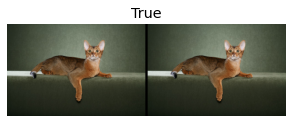

In [39]:
img = PILImage.create(files[0]) #create the image
s = SiameseImage(img, img, True)#Pass the images through the Siamese Image class and also pass the
#Boolean 
#It returns the concatenated Image
s.show();

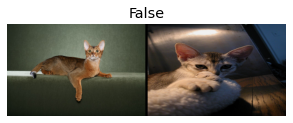

In [40]:
img1 = PILImage.create(files[1])
s1 = SiameseImage(img, img1, False)
s1.show();

Transforms class about which we discussed earlier can be applied onto tuples and subclasses too.That
is wht fastuple was passed which enables us to apply transform on each image in Simaese class and our
files are in tuples format so when we pass each element of the files the transform is applied on
each image in the tuple.

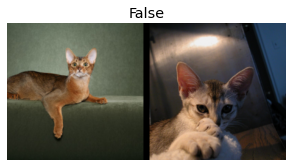

In [41]:
s2 = Resize(224)(s1)
s2.show();

Now we can build a custom Transform to be applied to images in our Siamese model.Let' define a label
function to find the classes for the image.

In [42]:
def label_func(fname):
    return re.match(r'^(.*)_\d+.jpg$', fname.name).groups()[0]

The transform picks up any image from the files with a 0.5 probability from the same class so returns
a True Label else if from different class it returns a False label.In the next code cell we will
define the SiameseTransform in which we use ._draw function which does this.

This label function will return a True label with two images if it draws images from the same groups,
else if picks up images from different groups,it will return a False.While we run these transforms on
training and validation sets,for training sets it will randomly pick the images from the set whereas
with validation sets the random pick is only during initialization.That is why passing splits is also
important.

We define a SiameseTransform which takes the files,label_function and the splits.The labels are \
defined by mapping the label function on each element in files which is a tuple.Next we collect the 
labels for each image in the files by passing the list of labels.

In [43]:
class SiameseTransform(Transform):
    def __init__(self, files, label_func, splits):
        self.labels = files.map(label_func).unique()
        self.lbl2files = {l: L(f for f in files if label_func(f) == l) 
                          for l in self.labels}
        self.label_func = label_func
        self.valid = {f: self._draw(f) for f in files[splits[1]]} #validation set files passed using 
        #the ._draw function which returns the file randomly selected using the labels.
        
    def encodes(self, f):
        f2,t = self.valid.get(f, self._draw(f))
        img1,img2 = PILImage.create(f),PILImage.create(f2)
        return SiameseImage(img1, img2, t)
    
    def _draw(self, f):
        same = random.random() < 0.5
        cls = self.label_func(f)
        if not same: 
            cls = random.choice(L(l for l in self.labels if l != cls)) 
        return random.choice(self.lbl2files[cls]),same

We create the instance of our Siamese Transform by passing the files,label function and the splits

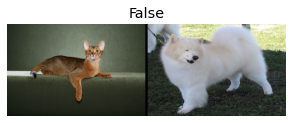

In [45]:
splits = RandomSplitter()(files)#splits using Random splitter function from fastai
tfm = SiameseTransform(files, label_func, splits)
tfm(files[0]).show();#tfm returns the Image sets randomly selected in tuples with the label

So in mid level API we discussed mainly about two object Datasets and TfmdLists using which we apply
Transforms.TfmdLists apply the a pipeline of transforms and Datasets applies transform pipelines 
simultaneous transforms and returns a tuple.Now our custom Transform Siamese Transform already returns
tuples so TfmdLists is used.

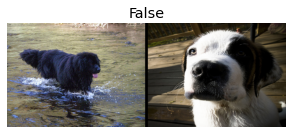

In [46]:
tls = TfmdLists(files, tfm, splits=splits) #Pass the files,the transform and the splits.
show_at(tls.valid, 0);

Now as per the regular process we pass the data through dataloaders by dataloaders method.As we had 
discussed previously about the difference in the arguments taken by DataBlock API and mid-level API.
In both though the dataloaders method is same but the arguments passed are different.In DataBlock
we had passed item_tfms and batch_tfms whereas here we pass "after_item" and "before_batch" and 
"after_batch"."Before_batch" and "after_batch" refers to the transforms applied before and after the 
batch is built.
Two extra tranforms are also applied apart from the Normalize and Resize.They are :
1.ToTensor-It converts into tensor.
2.IntToFloatTensor-Converts the tensor element values from int to float for performing any operations.
It also normalizes the value by dividing by 255.

In [47]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
    after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

Next we can now train a model as we have transformed our data and loaded it into dataloaders.Some more
transformations or functions would be needed then the regular ones we use while creating a learner 
with cnn_learner.We would learn about it in next lessons.

## Conclusion

We learnt about fastai's mid level data api in this lesson.Previously we learnt about DataBlock API.
Fastai provides us the facility of training a model in few lines of code instead of the big lines of 
code.The high level DataBlock API allows us to perform many operations needed for data preparation
in one go.Below it the midlevel api provides flexibility to apply transformations on the data.Since
our real life data would be very different and in raw form we would be required to apply transforms
according to our use.Midlevel API can surve that purpose.

## Questionnaire

1. Why do we say that fastai has a "layered" API? What does it mean?.
1. Why does a `Transform` have a `decode` method? What does it do?
1. Why does a `Transform` have a `setup` method? What does it do?
1. How does a `Transform` work when called on a tuple?
1. Which methods do you need to implement when writing your own `Transform`?
1. Write a `Normalize` transform that fully normalizes items (subtract the mean and divide by the standard deviation of the dataset), and that can decode that behavior. Try not to peek!
1. Write a `Transform` that does the numericalization of tokenized texts (it should set its vocab automatically from the dataset seen and have a `decode` method). Look at the source code of fastai if you need help.
1. What is a `Pipeline`?
1. What is a `TfmdLists`? 
1. What is a `Datasets`? How is it different from a `TfmdLists`?
1. Why are `TfmdLists` and `Datasets` named with an "s"?
1. How can you build a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. How do you pass `item_tfms` and `batch_tfms` when building a `DataLoaders` from a `TfmdLists` or a `Datasets`?
1. What do you need to do when you want to have your custom items work with methods like `show_batch` or `show_results`?
1. Why can we easily apply fastai data augmentation transforms to the `SiamesePair` we built?

In [ ]:
Ans-1.Layered api means fastai allows us to perform some tasks or operations in a few lines of code
rather then big codes when it is in a particular state.There are high level and mid level APIs.
Ans-2.The decode method helps in getting the original data back on which the transforms are applied.
Transformed data is passed and it returns the original data back.
Ans-3.Transform object is like function and the setup method helps in initializing some additional
inner functions inside it.(Example of vocab in case of NLP)
Ans-4.Transforms can be applied on tuples .Data is always stored as a tuples containing the input 
and the target.It is not applied on tuple as a whole instead it is applied on the input separately
and the output simulatenously.
Ans-5.We need to apply setup and decode method when we write our own Transform.
Ans-6.class Normalize(Transform):
    def setups(self,items):
        self.mean=sum(items)/len(items)
        self.std=math.sqrt(((items-self.mean)**2)/len(items))
    def encodes(self,x):
        return((x-self.mean)/self.std)
    def decodes(self,x):
        return((x*self.std)+self.mean)
Ans-7 class numericalize(Transform):
    def setups
Ans-8 A pipeline object allows us to apply multiple transforms in order to any data.We just need to
pass a list of transforms.
Ans-9 TfmdLists is a fastai object in midlevel API.Stands for transformed collections.Pipeline allows
us to apply successive transformations.TfmdLists allows us to pass these pipeline transforms through 
our data files.We pass the files and pipeline transforms and it returns the transformed data.
Ans-10
And-11 These objects have a "s" in them because we handle training and validation data differently by
passing the splits argument which has the indexes for the sets.Thus we can access the training and
validation data both using the .train and .valid attributes.
Ans-11 Datasets return a tuple in result and allow us to apply 2 or more pipelines on the data.
Therefore often we pass x_tfms and y_tfms differently for input and labels and later also the splits 
argument for training and validation set.
Ans-12 Dataloaders can be built from these objects simply using the dataloaders method which is same 
for both.For text data we generally don't pass other transforms such as after_batch and before_batch.
But for vision data some Image transformations are passed through dataloaders by after_batch and 
before_batch.
Ans-13 They are passed as "before_batch" and "after_batch" respectively.
Ans-14 If our images are not tensors they can be resized and converted into the tensors within the 
same transform so we can use show_batch or show_images method on them.
Ans-15 We pass the data as a fastuple which allows us to apply any transform on each image in each
tuple.That is why we can even apply data augmentation transforms on the images.

1. Use the mid-level API to prepare the data in `DataLoaders` on your own datasets. Try this with the Pet dataset and the Adult dataset from Chapter 1.
1. Look at the Siamese tutorial in the fastai documentation to learn how to customize the behavior of `show_batch` and `show_results` for new type of items. Implement it in your own project.

## Understanding fastai's Applications: Wrap Up

Congratulations—you've completed all of the chapters in this book that cover the key practical parts of training models and using deep learning! You know how to use all of fastai's built-in applications, and how to customize them using the data block API and loss functions. You even know how to create a neural network from scratch, and train it! (And hopefully you now know some of the questions to ask to make sure your creations help improve society too.)

The knowledge you already have is enough to create full working prototypes of many types of neural network applications. More importantly, it will help you understand the capabilities and limitations of deep learning models, and how to design a system that's well adapted to them.

In the rest of this book we will be pulling apart those applications, piece by piece, to understand the foundations they are built on. This is important knowledge for a deep learning practitioner, because it is what allows you to inspect and debug models that you build and create new applications that are customized for your particular projects.